# Ocean heat content (OHC) in the SPNA and NSEA from ECCOv4r4

In [1]:
import numpy as np
import xarray as xr

import shapely
import geopandas as gpd
import salem

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load salinity from ECCOv4r4

In [2]:
ecco = xr.open_dataset('/mnt/efs/data/ecco/eccov4r4_interp_theta.nc')

### Set spatial and temporal range

In [3]:
south,north,west,east = 40,90,-110,45

tstart = '1992-01-01'
tend = '2017-12-31'

## Heat content
The heat content for each grid point is estimated as
$$ H = \rho\,c_p\int_{-D}^\eta \theta \, dz $$

$$ H_{SPNA} =  \rho\,c_p\oint \int_{-D}^\eta \theta \, dz\; dA = \rho\,c_p\iiint \theta\; dV $$

In [4]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

In [5]:
D = 700

In [6]:
# Volume
#vol = (ecco.dz*ecco.area).sel(lat=slice(south,north),lon=slice(west,east))
vol = (ecco.dz*ecco.area).sel(lat=slice(south,north),lon=slice(west,east),depth=slice(0,D))

In [7]:
#temp = ecco.temperature.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))
temp = ecco.temperature.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east),depth=slice(0,D))

In [12]:
print('D = ',temp.depth[-1].values,'m')

D =  634.7349853515625 m


### Integrate over SPNA and NSEA

In [13]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [14]:
coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]

In [15]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [16]:
# Heat content (J)
ohc_spna = (temp*vol).salem.roi(shape=gdf_spna.loc[[0]]).sum(dim=['depth','lat','lon'])*rhoconst*c_p
ohc_nsea = (temp*vol).salem.roi(shape=gdf_nsea.loc[[0]]).sum(dim=['depth','lat','lon'])*rhoconst*c_p

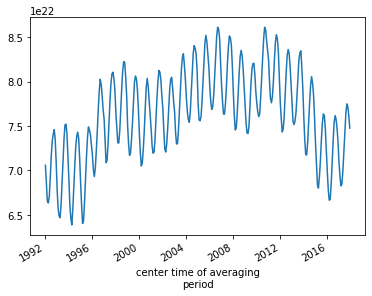

In [17]:
ohc_spna.plot()

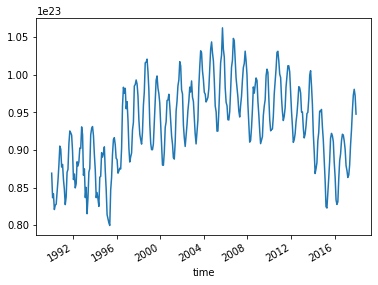

In [15]:
ds_spna = ohc_spna.to_dataset(name='ohc')
ds_nsea = ohc_nsea.to_dataset(name='ohc')

In [18]:
ohc_anom = ohc_spna - ohc_spna.mean('time')
#ohc_anom = ohc.groupby('time.month') - ohc.groupby('time.month').mean('time')

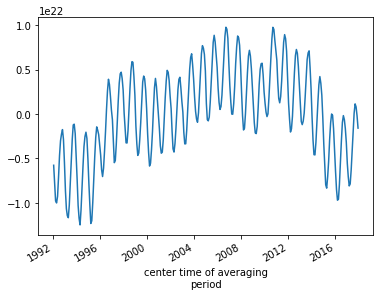

In [19]:
ohc_anom.plot()

In [20]:
df = ohc_anom.to_dataframe(name='ohc')

In [21]:
# Save with index column (time)
df.to_csv('/mnt/efs/data/eccov4r4_hc_spna_upper700m_monthly.csv', index=True)

In [21]:
ds = ohc_anom.to_dataset(name='ohc')
ds.time.attrs = []